<a href="https://colab.research.google.com/github/Afag-Ramazanova/Explainable_AI_assignments/blob/main/mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability


*Afag* *Ramazanova*




## Part 1 — Data + Model Setup

In [37]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# All 3-bit patterns
X_np = np.array(list(itertools.product([0., 1.], repeat=3)), dtype=np.float32)
# Label = 1 if odd number of ones, else 0
y_np = np.array([int(row.sum() % 2 == 1) for row in X_np], dtype=np.int64)

X = torch.tensor(X_np, dtype=torch.float32, device=device)
y = torch.tensor(y_np, dtype=torch.long, device=device)

print("X shape:", X.shape)
print("y:", y_np)

X shape: torch.Size([8, 3])
y: [0 1 1 0 1 0 0 1]


## Define a Tiny MLP

In [36]:
class TinyParityNet(nn.Module):
    def __init__(self, hidden_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x, return_hidden=False):
        z = self.fc1(x)
        h = self.act(z)
        logits = self.fc2(h)
        if return_hidden:
            return logits, h, z
        return logits

model = TinyParityNet().to(device)
model

TinyParityNet(
  (fc1): Linear(in_features=3, out_features=4, bias=True)
  (act): Tanh()
  (fc2): Linear(in_features=4, out_features=2, bias=True)
)

## Training Loop

Training accuracy: 100.0%


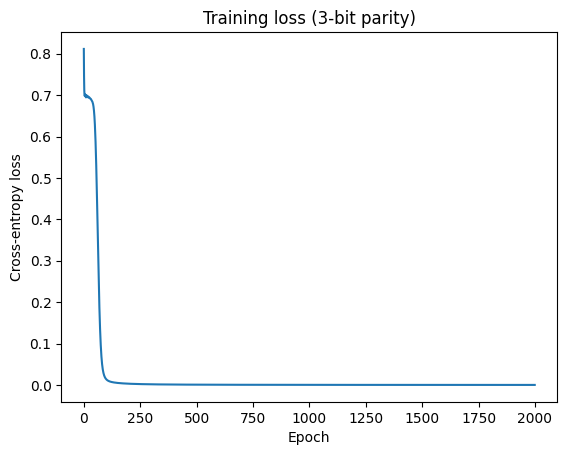

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

loss_history = []
for epoch in range(2000):
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

with torch.no_grad():
    preds = model(X).argmax(dim=1)
    train_acc = (preds == y).float().mean().item()

print(f"Training accuracy: {train_acc*100:.1f}%")

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Training loss (3-bit parity)")
plt.show()


## Extract Weights & Hidden States

Hidden activations (rows = inputs, cols = neurons):
[[-1.    -0.959  0.968 -0.651]
 [-0.938  0.978  1.    -0.791]
 [-0.938  0.977  1.    -0.788]
 [ 0.967  1.     1.    -0.877]
 [-0.966 -1.    -0.782  0.995]
 [ 0.939 -0.908  0.957  0.991]
 [ 0.939 -0.914  0.946  0.991]
 [ 1.     0.99   1.     0.984]]


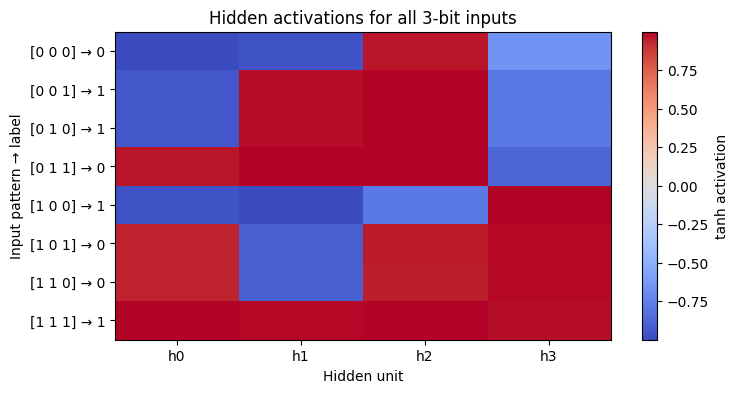

In [45]:
with torch.no_grad():
    logits, H_torch, _ = model(X, return_hidden=True)
    H = H_torch.cpu().numpy()

print("Hidden activations (rows = inputs, cols = neurons):")
print(np.round(H, 3))

plt.figure(figsize=(8, 4))
plt.imshow(H, cmap="coolwarm", aspect="auto")
plt.colorbar(label="tanh activation")
plt.xticks(range(H.shape[1]), [f"h{j}" for j in range(H.shape[1])])
plt.yticks(range(H.shape[0]), [f"{X_np[i].astype(int)} → {y_np[i]}" for i in range(H.shape[0])])
plt.xlabel("Hidden unit")
plt.ylabel("Input pattern → label")
plt.title("Hidden activations for all 3-bit inputs")
plt.show()



## Showing the correlations with labels

In [46]:
# Correlation with label
cor_list = []
for j in range(H.shape[1]):
    r, p = pearsonr(H[:, j], y_np.astype(float))
    cor_list.append((j, r, p))

print("\nNeuron correlations with label:")
for j, r, p in cor_list:
    print(f"  h{j}: r={r:.3f}, p={p:.4f}")

best_idx = max(range(len(cor_list)), key=lambda j: abs(cor_list[j][1]))
print(f"\nMost label-aligned neuron: h{best_idx} (r={cor_list[best_idx][1]:.3f})")


Neuron correlations with label:
  h0: r=-0.479, p=0.2293
  h1: r=0.482, p=0.2264
  h2: r=-0.354, p=0.3894
  h3: r=-0.008, p=0.9858

Most label-aligned neuron: h1 (r=0.482)


## Ablation Analysis

In [40]:
def eval_accuracy(model, X, y):
    with torch.no_grad():
        logits = model(X)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

def eval_with_hidden_ablation(model, X, y, neuron_idx=None):
    model.eval()
    with torch.no_grad():
        logits, h, _ = model(X, return_hidden=True)
        if neuron_idx is not None:
            h[:, neuron_idx] = 0.0  # ablate this unit
        logits_new = model.fc2(h)
        preds = logits_new.argmax(dim=1)
        acc = (preds == y).float().mean().item()
    return acc

baseline_acc = eval_with_hidden_ablation(model, X, y, neuron_idx=None)
print(f"Baseline accuracy: {baseline_acc*100:.1f}%")

for j in range(4):
    acc_j = eval_with_hidden_ablation(model, X, y, neuron_idx=j)
    print(f"Ablating h{j}: accuracy = {acc_j*100:.1f}%")

Baseline accuracy: 100.0%
Ablating h0: accuracy = 87.5%
Ablating h1: accuracy = 50.0%
Ablating h2: accuracy = 100.0%
Ablating h3: accuracy = 87.5%


## Ablation Sweep

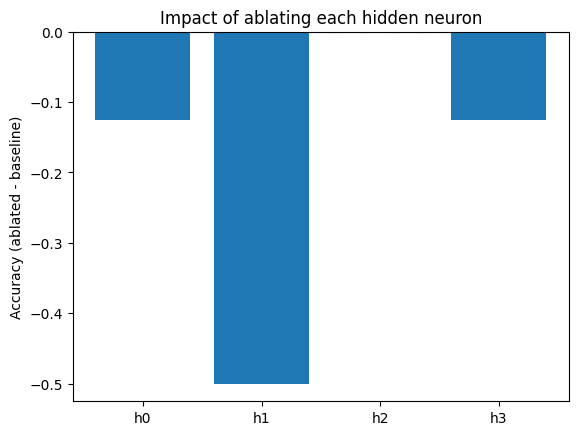

In [41]:
deltas = []
for j in range(4):
    acc_j = eval_with_hidden_ablation(model, X, y, neuron_idx=j)
    deltas.append(acc_j - baseline_acc)

plt.figure()
plt.bar(range(4), deltas)
plt.axhline(0, linestyle="--", color="gray")
plt.xticks(range(4), [f"h{j}" for j in range(4)])
plt.ylabel("Accuracy (ablated - baseline)")
plt.title("Impact of ablating each hidden neuron")
plt.show()

Average input saliency per bit: [0.2502 0.2754 0.2776]


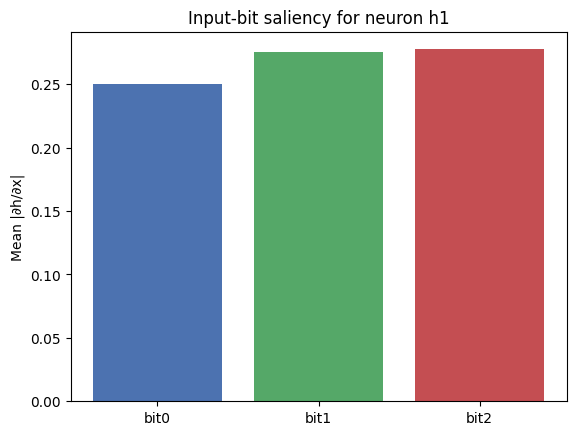

In [44]:
X_sal = X.clone().detach().requires_grad_(True)

logits, h_vals, _ = model(X_sal, return_hidden=True)

# focus on the sum of activations of the chosen neuron
target_neuron = h_vals[:, best_idx].sum()

# Clear existing gradients if any
model.zero_grad()
if X_sal.grad is not None:
    X_sal.grad.zero_()

# Compute gradients of neuron activation w.r.t. input
target_neuron.backward()

# Convert gradient to numpy
grad_np = X_sal.grad.detach().cpu().numpy()
bit_importance = np.mean(np.abs(grad_np), axis=0)

print("Average input saliency per bit:", np.round(bit_importance, 4))

plt.figure()
plt.bar(range(3), bit_importance, color=['#4c72b0','#55a868','#c44e52'])
plt.xticks(range(3), ["bit0","bit1","bit2"])
plt.ylabel("Mean |∂h/∂x|")
plt.title(f"Input-bit saliency for neuron h{best_idx}")
plt.show()

## Pt3. EXPLAIN

To understand how the network solves 3 bit parity, I focused on neuron 'h1', which showed the strongest relationship with the label. In the hidden activation matrix, h1 displayed a clear separation between odd-parity and even-parity inputs: its outputs tended to cluster near one sign for odd-parity vectors and the opposite sign for even-parity vectors. This already suggested that h1 might be implementing a core non-li
near feature directly tied to the parity structure.

To verify that initial intuition, I computed the **correlation** between each hidden neuron’s activation and the label. Neuron h1 had the highest correlation (r = 0.482), meaning its output varies most consistently with the odd/even target. Other neurons had weaker relationships, and h3 exhibited almost no alignment at all.

Next, I performed causal ablations: I zeroed out each hidden neuron and re evaluated the model. If a neuron is functionally important, ablation should hurt accuracy. Indeed, ablating neuron h1 dropped accuracy from 100% to 50%, collapsing performance to chance. This is the clearest possible signal that h1 is not merely correlated with the label it is causally necessary for correct classification.

In contrast, ablating h0 and h3 produced only mild degradation (accuracy ≈ 87.5%), and h2 could be removed entirely with no impact. This confirms that multiple neurons participate in shaping the decision boundary, but only h1 carries the decisive non-linear transformation required to separate odd from even patterns.

`Put together, these analyses support the hypothesis that h1 is the network’s parity feature detector. `It represents a specific non-linear combination of the three bits—something like an approximate XOR of inputs—that the final linear layer can then use to perfectly classify parity. The heatmap visualization, correlation analysis, and the severe loss after ablation all converge on the same interpretation: h1 encodes the model’s core concept of “oddness.”


## Pt4. REFLECT

Working through this tiny network made it much easier to see how hidden units begin to specialize, even in very small models. I was surprised by how clearly one neuron (h1) emerged as the main parity detector, while others contributed only partially or not at all. The ablation test was the most compelling part: seeing accuracy collapse from 100% to 50% after removing a single neuron made the internal computation feel concrete and causal, not abstract.

One part that was initially confusing was understanding why some neurons showed low correlation but still affected accuracy slightly. It reminded me that correlation alone doesn’t tell the whole story neurons can encode supporting non-linear features that aren’t directly aligned with the label but still matter for shaping the final decision.

If I had more time, I would explore how these neurons evolve throughout training and whether different random seeds consistently produce a similar “parity neuron.” I am also curious how this behavior scales for 4 bit or 5 bit parity, and whether the model begins to distribute information across more units or leans even more heavily on a single specialized neuron.

*ChatGPT, developed by OpenAI contributed to the notebook content.*